<a href="https://colab.research.google.com/github/RGologorsky/fastproj/blob/master/Image_Segmentation_Hair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Segment pixels representing hair

# Imports

In [0]:
%matplotlib inline

In [0]:
%%capture
!pip install fastai2

In [0]:
import tensorflow as tf

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [5]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# print n items in list, w each item on newline
def pprint_l(n,*args): 
  if n == -1: n = len(args[0])
  for lst in args: print(f"len {len(lst)}:", *lst[:n], sep="\n", end="\n\n")

# Data

In [0]:
proj = "segmentation"
base_path = Path("drive/My Drive/fastai_proj")
proj_path = base_path/proj

Path.BASE_PATH = proj_path

In [8]:
pprint_l(-1, proj_path.ls())

len 2:
drive/My Drive/fastai_proj/segmentation/face_segment_data_sampleset.zip
drive/My Drive/fastai_proj/segmentation/data



In [0]:
data_src = proj_path/"face_segment_data_sampleset.zip"
data_dest = proj_path/"data"

In [0]:
# !unzip -qq "$data_src" -d "$data_dest"

Define training set (x), labelled set (y), and validation set (subset of training set).

In [0]:
# given path x/y/z, returns folder name z
def get_folder_name(x): return re.search("([^\/])*$", str(x)).group(0)

# given input string "aaa_bbb_ccc", returns up to first underscore "aaa"
def get_stem(s): return re.search("^([^_])*", s).group(0)

# returns folder stem
def get_folder_stem(x): return get_stem(get_folder_name(x))

In [12]:
data_dirs = [get_folder_name(x) for x in data_dest.ls()]
data_dirs

['malekumar_env01',
 'maleshawn_env01',
 'male20_blackhair_browneyes_env06',
 'male22_blackhair_browneyes_env04',
 'multiperson_env01',
 'maleandrew2_env01',
 'malecarlos_env01',
 'real',
 'sampleset.xml',
 'femalefelice_env04',
 'femalejanna_blondhair_smile_env07',
 'femalemei_blackhair_browneyes_env10',
 'femalemira_blackhair_env01',
 'femalemyriam_env01',
 'femalesophia_brownhair_smile_env05',
 'labels',
 'models']

In [0]:
path_lbls = data_dest/"labels"

In [0]:
valid_dirs = ['malekumar_env01', 'male22_blackhair_browneyes_env04', 'femalesophia_brownhair_smile_env05']
train_dirs = [x for x in data_dirs if x != "labels"]
train_only_dirs = [x for x in train_dirs if x not in valid_dirs] 

In [15]:
%%time
full_lbl_names        = get_image_files(path_lbls)
full_valid_names      = get_image_files(data_dest, folders=valid_dirs)
full_train_names      = get_image_files(data_dest, folders=train_dirs)
full_train_only_names = get_image_files(data_dest, folders=train_only_dirs)

CPU times: user 12 ms, sys: 4.68 ms, total: 16.7 ms
Wall time: 40.9 ms


In [16]:
pprint_l(2,full_valid_names, full_train_only_names, full_lbl_names)

len 75:
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0003.png
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0024.png

len 325:
drive/My Drive/fastai_proj/segmentation/data/maleshawn_env01/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/maleshawn_env01/headrende0021.png

len 400:
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0002.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0062.png



In [0]:
get_y_fn = lambda x: path_lbls/get_folder_stem(x.parents[0])/f"{x.stem}.png"

# View image/label

In [0]:
idx = 20
fn = data_dest/"maleandrew2_env01/headrende0240.png"

In [0]:
# training image
img_fn = full_train_names[idx] if idx != -1 else fn
img = PILImage.create(img_fn)
#img.show()

In [0]:
# labeled image
img_lbl_fn = get_y_fn(img_fn)
img_lbl = PILImage.create(img_lbl_fn)
# img_lbl.show()

In [0]:
# masked image
mask = PILMask.create(img_lbl_fn)
# mask.show()

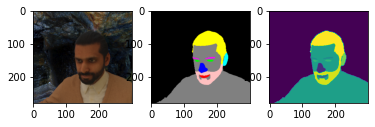

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img)
ax2.imshow(img_lbl)
ax3.imshow(mask)
plt.show()

In [22]:
img_lbl_t = tensor(img_lbl)
img_lbl_t.shape #img_lbl_t

torch.Size([280, 300, 3])

In [23]:
mask_t = tensor(mask)
mask_t.shape #mask_t

torch.Size([280, 300])

In [24]:
np.array(mask.shape)

array([280, 300])

In [25]:
idx1,idx2 = 200,150
img_lbl_t[idx1,idx2], mask_t[idx1,idx2]

(tensor([255,   0,   0], dtype=torch.uint8), tensor(76, dtype=torch.uint8))

In [26]:
img_lbl_t.unique(),mask_t.unique()

(tensor([  0, 128, 192, 255], dtype=torch.uint8),
 tensor([  0,  29,  76, 105, 128, 150, 179, 211, 226], dtype=torch.uint8))

# Check img sizes, file exts, labels

In [0]:
import imageio
import pandas as pd

In [0]:
# check file suffixes of training/labels
def get_file_exts(fns):
    suffixes = np.asarray([fn.suffix for fn in fns])
    unique, idxs, cnts = np.unique(suffixes, return_index=True, return_counts=True)
    return dict(list(zip(unique,zip(cnts,fns[idxs]))))
# check img sizes of training fns
def get_img_sizes(fns):
    sizes = np.asarray([str(Image.open(fn).shape) for fn in fns])
    unique, idxs, cnts = np.unique(sizes, return_index=True, return_counts=True)
    return pd.DataFrame(zip(unique, cnts, fns[idxs]), columns =["sizes", "n_files", "fn"])
    #return dict(list(zip(unique,zip(cnts,fns[idxs]))))

# check unique labels in labelled imgs
def check_missing(fns):
  masks = [np.unique(PILMask.create(fn)) for fn in fns]
  lens = [len(l) for l in masks]
  flat = [item for lst in masks for item in lst]
  unique, idxs, cnts = np.unique(flat, return_counts=True, return_index=True) 
  return pd.DataFrame(zip(unique, cnts, idxs), columns =["label", "n_files", "flat_idx"]),lens
  #dict(zip(unique, zip(cnts, idxs))),lens

def flat2idx(idx_flat,lens):
  sums = np.cumsum(lens)
  return np.searchsorted(sums, idx_flat, side ='right')

In [20]:
%%time
lbls,lens = check_missing(full_lbl_names[:100])

KeyboardInterrupt: ignored

In [0]:
lbls

,label,n_files,idx
0,0,100,0
1,29,100,1
2,76,100,2
3,105,100,3
4,128,100,4
5,150,100,5
6,179,79,6
7,226,100,7
8,255,50,405


In [0]:
flat_idx = 405
label = 255

In [0]:
idx = flat2idx(flat_idx, lens)
lbl_fn = full_lbl_names[idx]

In [0]:
mask = PILMask.create(lbl_fn)
mask_arr = np.array(mask)
mask_arr[mask_arr != label] = 0
binary_mask = PILMask.create(mask_arr)

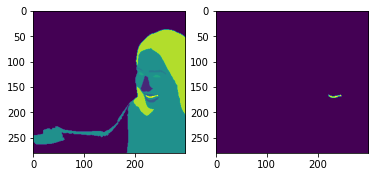

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mask)
ax2.imshow(binary_mask)

In [0]:
%%time
e = get_file_exts(full_train_names[:10])

CPU times: user 399 µs, sys: 0 ns, total: 399 µs
Wall time: 409 µs


In [0]:
e

{'.png': (10, Path('data/malekumar_env01/headrende0003.png'))}

In [0]:
%%time
d = get_img_sizes(full_train_names[:10])

CPU times: user 6.45 ms, sys: 3.55 ms, total: 10 ms
Wall time: 30.8 ms


In [0]:
d

{'(280, 300)': (10, Path('data/malekumar_env01/headrende0003.png'))}

# Codes

Codes found by inspection

In [0]:
# px wo code is given code "void"
void_code = "void"

In [0]:
label2code= {
    0: "bg",
    29: "nose",
    76: "mouth",
    105: "eyebrow",
    128: "skin",
    150: "eye",
    179: "ear",
    211: "facial_hair",
    226: "hair",
    255: "teeth",
}

In [23]:
code2label = {code:label for label,code in label2code.items()}
code2label

{'bg': 0,
 'ear': 179,
 'eye': 150,
 'eyebrow': 105,
 'facial_hair': 211,
 'hair': 226,
 'mouth': 76,
 'nose': 29,
 'skin': 128,
 'teeth': 255}

In [24]:
codes = [str(c) for c in label2code.values()]
codes

['bg',
 'nose',
 'mouth',
 'eyebrow',
 'skin',
 'eye',
 'ear',
 'facial_hair',
 'hair',
 'teeth']

# Experiment subset


In [0]:
n_train_only = 10
n_valid = 30

In [26]:
sm_train_only_names = np.random.permutation(full_train_only_names)[:n_train_only]
sm_valid_names      = np.random.permutation(full_valid_names)[:n_valid]
sm_train_names = np.append(sm_train_only_names, sm_valid_names)
pprint_l(2, sm_train_names)

len 40:
drive/My Drive/fastai_proj/segmentation/data/real/11298811243_cc9b220a4d_o_scaled_scaled.jpg
drive/My Drive/fastai_proj/segmentation/data/real/image10878.jpg_RESAMPLED_4fdb596686055b3_scaled.png



# Dataloaders

Set classes to classify (subset of all codes)

In [0]:
classes = ['facial_hair', 'hair', 'eyebrow']

Relabel y masks according to classes

In [28]:
labels = [int(code2label[c]) for c in classes]
new_labels = [x for x in range(len(labels))] # float
void_label = len(labels) #float
labels, new_labels, void_label

([211, 226, 105], [0, 1, 2], 3)

Tensorflow get_y

In [0]:
# BEWARE importting tensorflow may override dataloaders?
# # build a lookup table
# table = tf.lookup.StaticHashTable(
#     initializer=tf.lookup.KeyValueTensorInitializer(
#         keys = tf.constant(labels), values = tf.constant(new_labels)),
#         default_value=void_label,
# )

# def get_y_tf(fn):
#   y = tf.constant(np.array(PILMask.create(get_y_fn(fn)), dtype="int32"))
#   return PILMask.create(table.lookup(y))

## Numpy get_y

In [30]:
relabel_dict = dict(zip(labels, new_labels))
relabel_dict

{105: 2, 211: 0, 226: 1}

In [0]:
def get_y_np(fn):
  y = np.array(PILMask.create(get_y_fn(fn)))
  void_mask = np.isin(y, labels, invert=True)
  for label in labels: y[y==label] = relabel_dict[label]
  y[void_mask] = void_label
  return PILMask.create(y)

Test get_y (relabel mask)

In [0]:
fn = sm_train_names[0]

In [33]:
u = np.unique(PILMask.create(get_y_fn(fn)))
u

array([  0,  29,  76, 105, 128, 150, 179, 226, 255], dtype=uint8)

In [34]:
%%time
y_np = get_y_np(fn)

CPU times: user 3.63 ms, sys: 106 µs, total: 3.74 ms
Wall time: 9.6 ms


In [35]:
tensor(y_np)

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.uint8)

In [36]:
y_np.shape, np.unique(y_np)

((258, 256), array([1, 2, 3], dtype=uint8))

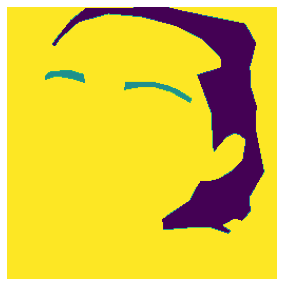

In [37]:
show_image(y_np)

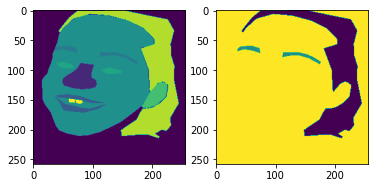

In [38]:
# test
y_old = PILMask.create(get_y_fn(fn))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(y_old)
ax2.imshow(y_np)

In [0]:
def get_items_fn(src): return sm_train_names
def is_valid(o): return o in sm_valid_names

In [40]:
get_img_sizes(sm_train_names)

,sizes,n_files,fn
0,"(256, 256)",1,drive/My Drive/fastai_proj/segmentation/data/real/image10878.jpg_RESAMPLED_4fdb596686055b3_scaled.png
1,"(258, 256)",1,drive/My Drive/fastai_proj/segmentation/data/real/11298811243_cc9b220a4d_o_scaled_scaled.jpg
2,"(280, 300)",38,drive/My Drive/fastai_proj/segmentation/data/femalemyriam_env01/headrende0480.png


## Datablock

In [0]:
def get_dls(bs, presize=460, resize=224):
  db = DataBlock(
    blocks=(ImageBlock, MaskBlock(classes)),
    get_items = get_items_fn,
    get_y = get_y_np,
    splitter= FuncSplitter(is_valid),
    item_tfms = Resize(presize),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
  )
  return db.dataloaders("data_dest", bs=bs)

Time test

In [42]:
%%time
dls = get_dls(bs=10, presize=224, resize=224)
dls.vocab = classes

CPU times: user 2.15 s, sys: 857 ms, total: 3.01 s
Wall time: 3.02 s


In [43]:
dls.train_ds, dls.valid_ds

((#10) [(PILImage mode=RGB size=256x258, PILMask mode=L size=256x258),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280)],
 (#30) [(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size

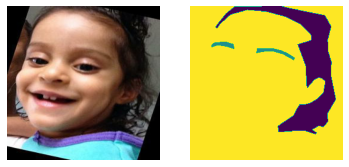

In [44]:
_, (ax1, ax2) = plt.subplots(1,2)
show_image(dls.train_ds[0][0], ax=ax1)
show_image(dls.train_ds[0][1], ax=ax2)

In [45]:
b = dls.train.one_batch()
b = dls.train.decode(b)
b[0].shape, b[1].shape

(torch.Size([10, 3, 224, 224]), torch.Size([10, 224, 224]))

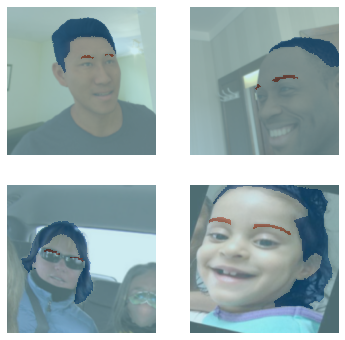

In [46]:
dls.show_batch(nrows=2, max_n=4)

# Model

In [47]:
classes

['facial_hair', 'hair', 'eyebrow']

### accuracy metrics

In [0]:
def acc_non_void(input, target):
  target = target.squeeze(1)
  mask = target != void_label
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

class_labels = [relabel_dict[code2label[h]] for h in classes]
code = "hair"
label = relabel_dict[code2label[code]]

def acc_hair(input, target, code="hair"):
  target = target.squeeze(1)
  mask = target == label
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
xb,yb = dls.one_batch()

In [50]:
xb.shape, yb.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10, 224, 224]))

In [51]:
acc_non_void(xb,yb), acc_hair(xb,yb)

(tensor(0.0340, device='cuda:0'), tensor(0.0049, device='cuda:0'))

In [0]:
metrics=[acc_non_void, acc_hair]

In [0]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
learn = unet_learner(dls, resnet34, metrics=metrics, config=config,
                     opt_func=opt).to_fp16()

In [55]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

RuntimeError: ignored

In [0]:
lr = 1e-3

In [0]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_non_void,time
0,0.808055,0.447953,0.892606,00:09
1,0.486081,0.247602,0.944201,00:08
2,0.349532,0.195758,0.948975,00:08
3,0.277806,0.189419,0.947714,00:08
4,0.237469,0.238051,0.939774,00:08
5,0.200387,0.164819,0.954736,00:08
6,0.173574,0.201072,0.954714,00:08
7,0.152239,0.178482,0.953292,00:08
8,0.137579,0.186176,0.956236,00:08
9,0.122574,0.177835,0.957879,00:08


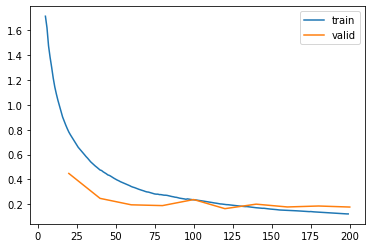

In [0]:
learn.recorder.plot_loss()

In [0]:
# learn.fit_one_cycle(10,slice(lr),pct_start=0.9,wd=wd)
learn.save('stage-1-sm')


In [0]:
learn.load('stage-1-sm');

## unfreeze

In [0]:
lrs = slice(lr/400, lr/4)

In [0]:
learn.unfreeze()
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_non_void,time
0,0.096373,0.198082,0.953500,00:08
1,0.093713,0.187838,0.957767,00:08
2,0.090893,0.162934,0.959607,00:09
3,0.089143,0.211928,0.959543,00:09
4,0.088803,0.163987,0.961142,00:09
5,0.085356,0.161598,0.961059,00:09
6,0.087018,0.164905,0.957952,00:09
7,0.083801,0.152314,0.961185,00:09
8,0.079379,0.195121,0.961376,00:09
9,0.078194,0.148619,0.963538,00:08


In [0]:
learn.save('model-1-sm')

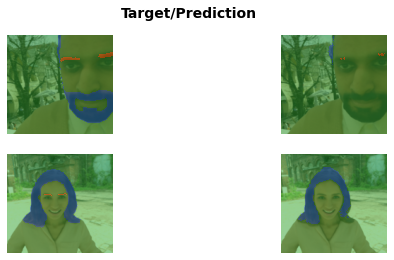

In [0]:
learn.show_results(max_n=4, figsize=(9,4))

In [0]:
del learn
import gc
gc.collect()

19793

In [0]:
dls = get_dls(orig_bs, orig_size)

In [0]:
dls.vocab = classes

In [0]:
# learn = unet_learner(dls, resnet34, metrics=metrics).to_fp16() # add model_dir="foodir"
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_non_void, config=config,
                     opt_func=opt).to_fp16()

In [0]:
learn.load("model-1-sm")

In [0]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

RuntimeError: ignored

In [0]:
lr_min, lr_steep

(3.981071586167673e-07, 1.737800812406931e-05)

In [0]:
lr = 3e-5
learn.fit_one_cycle(12, slice(lr/400,lr/4),pct_start=0.8,wd=wd)

epoch,train_loss,valid_loss,acc_hair,acc_non_void,time
0,0.268872,0.327772,nan,0.886362,00:29
1,0.266570,0.322345,nan,0.894002,00:29
2,0.261566,0.311978,nan,0.895471,00:29
3,0.264143,0.315752,nan,0.895811,00:29
4,0.255549,0.314701,nan,0.897361,00:29
5,0.256167,0.318969,nan,0.889945,00:29
6,0.256306,0.334395,nan,0.883928,00:29
7,0.252167,0.303931,nan,0.896596,00:29
8,0.250364,0.295724,nan,0.903060,00:29
9,0.239360,0.287429,nan,0.904591,00:29


In [0]:
learn.save("stage-2-904")

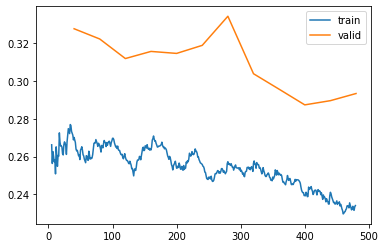

In [0]:
learn.recorder.plot_loss()